# Proyecto Final Aprendizaje Automático:

## Realizado por Santiago Castaño, Sebastian García y Daniel Giraldo

En este notebook trabajaremos con el conjunto de datos IEEE-CIS Fraud Detection, el cual proviene de una competencia en Kaggle orientada a la detección de transacciones fraudulentas en línea. El dataset incluye información transaccional, categórica y de dispositivos, lo que permite diseñar y evaluar modelos de machine learning para predecir si una transacción es fraudulenta o legítima.

El problema presenta un fuerte desbalance de clases, ya que la mayoría de transacciones no son fraudulentas, lo que representa un desafío adicional para los modelos de clasificación.

## Estrategia de Análisis

Exploración de Datos (EDA):
Se analizó la estructura del dataset, se identificaron variables poco informativas o redundantes y se realizó limpieza para optimizar el trabajo con los modelos.

### Preprocesamiento:
Se implementaron y compararon cuatro estrategias distintas para preparar los datos:

 - Sin preprocesamiento.
 - Escalado estándar con StandardScaler.
 - Reducción de dimensionalidad con PCA.
 - Escalado + PCA.

### Balanceo de Datos:
Para enfrentar el desbalance entre clases, se aplicó la técnica SMOTE (Synthetic Minority Over-sampling Technique) y se evaluó su impacto en el rendimiento de los modelos.

### Modelado:
Se entrenaron y evaluaron los siguientes algoritmos:

 - Random Forest Classifier
 - Support Vector Classifier (SVC)
 - Gradient Boosting Classifier

### Evaluación y Comparación:
Se midió el rendimiento de cada modelo bajo diferentes combinaciones de preprocesamiento y balanceo, principalmente a través de la métrica de accuracy.

## Objetivo

El objetivo principal de este trabajo es comparar el impacto del preprocesamiento y el balanceo de clases en el rendimiento de distintos modelos de clasificación, y así identificar la estrategia más adecuada para abordar el problema de detección de fraude en transacciones financieras.



El dataset fué tomado de: https://www.kaggle.com/datasets/phambacong/ieee-cis-fraud-detection


## Imports generales y funciones de ayuda.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

data_path = './train.csv'
data = pd.read_csv(data_path)

if "Unnamed: 0" in data.columns:
    transactions = data.drop(["Unnamed: 0"], axis=1)
elif "Unnamed" in data.columns:
    transactions = data.drop(["Unnamed"], axis=1)


def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        
        if np.issubdtype(col_type, np.datetime64):
                continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    return df

def summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

print("Importaciones finalizadas.")

Importaciones finalizadas.


## Exploración y optimización de los datos

Para entendimiento de los datos y por la anonimizacion de tantas caracteristicas, suponemos que la fecha inicial es el 11 de noviembre de 2017, esto es solo para entender la escala temporal, mas no significa en verdad nada dentro de nuestro dataset, la variable que utilizamos nos indica el numero de segundos desde el momento 0 de nuestro dataset hasta una transaccion.

Forma de las Características (Features): (590540, 435)
Forma de las Etiquetas (Labels): (590540,)

Primeras 5 filas del DataFrame:
   Unnamed: 0  TransactionID_x  isFraud  TransactionDT  TransactionAmt  \
0           0          2987000        0          86400            68.5   
1           1          2987001        0          86401            29.0   
2           2          2987002        0          86469            59.0   
3           3          2987003        0          86499            50.0   
4           4          2987004        0          86506            50.0   

   ProductCD  card1  card2  card3  card4  ...  id_31  id_32  id_33  id_34  \
0          4  13926  321.0  150.0      1  ...    123   32.0    164      3   
1          4   2755  404.0  150.0      2  ...     98   32.0     48      2   
2          4   4663  490.0  150.0      3  ...     44   24.0    132      3   
3          4  18132  567.0  150.0      2  ...     44   24.0    132      3   
4          1   4497  514.0  150.0      

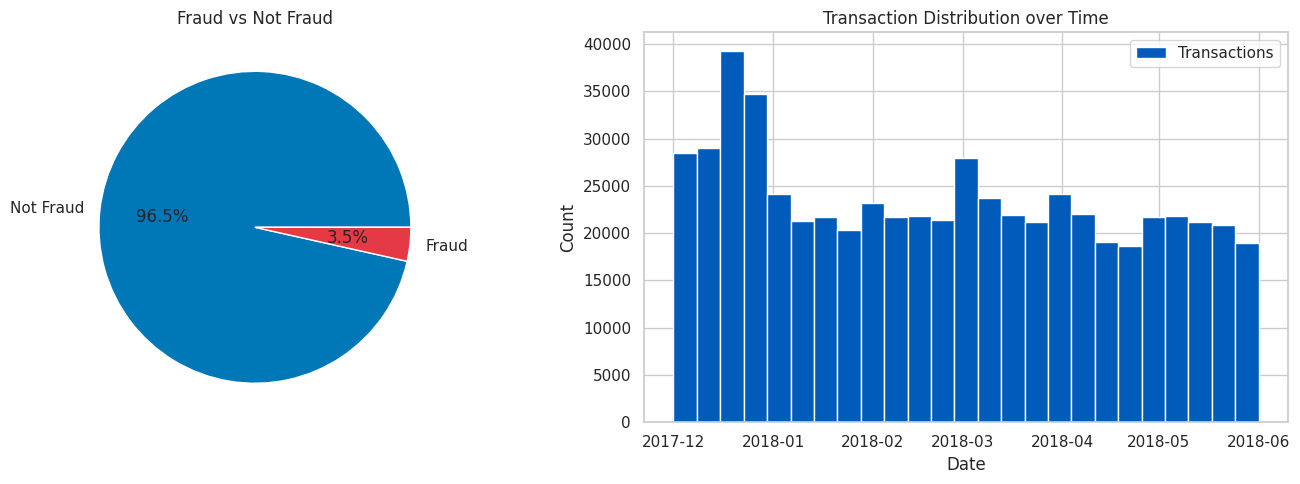


Conteo de clases: Counter({np.int8(0): 569877, np.int8(1): 20663})
Unnamed: 0         0.0
TransactionID_x    0.0
isFraud            0.0
TransactionDT      0.0
TransactionAmt     0.0
ProductCD          0.0
card1              0.0
card2              0.0
card3              0.0
card4              0.0
card5              0.0
card6              0.0
addr1              0.0
addr2              0.0
dist1              0.0
dist2              0.0
P_emaildomain      0.0
R_emaildomain      0.0
C1                 0.0
C2                 0.0
dtype: float64
Series([], dtype: float64)
Dataset Shape: (590540, 437)
                Name          dtypes  Missing  Uniques
0         Unnamed: 0           int32        0   590540
1    TransactionID_x           int32        0   590540
2            isFraud            int8        0        2
3      TransactionDT           int32        0   573349
4     TransactionAmt         float32        0    20902
..               ...             ...      ...      ...
432            i

In [2]:
data_reduced = reduce_mem_usage(data).copy()
del data

labels = data_reduced['isFraud'].values
features = data_reduced.drop(['isFraud'], axis=1).values


print('Forma de las Características (Features):', features.shape)
print('Forma de las Etiquetas (Labels):', labels.shape)
print('\nPrimeras 5 filas del DataFrame:')
print(data_reduced.head())

start_date = pd.to_datetime("2017-11-30")

# Convertimos TransactionDT en fecha real
data_reduced['TransactionDate'] = start_date + pd.to_timedelta(data_reduced['TransactionDT'], unit='s')

# Gráfico de clases

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].pie(
    data_reduced.isFraud.value_counts(), 
    labels=['Not Fraud', 'Fraud'], 
    autopct='%0.1f%%', 
    colors=['#0077b6', '#e63946']
)
axes[0].set_title("Fraud vs Not Fraud")

# Gráfico temporal
axes[1].hist(
    data_reduced['TransactionDate'], 
    bins=25, 
    color="#005BBB", 
    label='Transactions'
)
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Date')
axes[1].set_title('Transaction Distribution over Time')
axes[1].legend()

plt.tight_layout()
plt.show()



print("\nConteo de clases:", Counter(labels))


missing = data_reduced.isnull().mean().sort_values(ascending=False)
print(missing.head(20))


categorical_cols = data_reduced.select_dtypes(include=['object']).columns
print(data_reduced[categorical_cols].nunique().sort_values(ascending=False).head(20))

print(summary(data_reduced))

## Exploración y Comprensión del Dataset


### Información General
- **Número de registros:** `590,540`  
- **Número de características:** `435`  
- **Variable objetivo:** `isFraud` (0 = transacción legítima, 1 = fraude)


El conjunto de datos contiene información transaccional, de identidad y de dispositivos recopilada durante aproximadamente **seis meses**.  
Cada fila representa una transacción individual.


```python
Shape de las características: (590540, 435)
Shape de las etiquetas: (590540,)


Balance de Clases
Counter({0: 569877, 1: 20663})


Clase   Cantidad    Porcentaje
No Fraud (0)    569,877 96.5%
Fraud (1)   20,663  3.5%
```


**Interpretación:**
Existe un fuerte desbalance de clases, donde las transacciones fraudulentas representan tan solo el 3.5% del total.
Esto significa que un modelo que siempre prediga "no fraude" alcanzaría una alta precisión aparente (~96.5%) pero no detectaría fraudes reales, por lo que será necesario aplicar técnicas de balanceo (como SMOTE) y usar métricas más adecuadas que el accuracy, como F1-score, recall y ROC-AUC.


### Distribución Temporal


El gráfico de la derecha muestra la cantidad de transacciones registradas a lo largo del tiempo.


**Análisis:**


- Las transacciones cubren un rango temporal entre diciembre de 2017 y junio de 2018.
- Se observan picos de actividad en diciembre 2017 y enero 2018, posiblemente por la temporada de compras de fin de año.
- No hay vacíos de información, lo que indica un registro continuo.
- La estacionalidad sugiere que podrían crearse features temporales (día, mes, hora, fin de semana, etc.) para mejorar el desempeño de los modelos.


### Calidad y Completitud de Datos


El análisis inicial de valores nulos muestra que las primeras columnas presentan pocos o ningún valor faltante, aunque en etapas posteriores se identifican múltiples columnas con alto porcentaje de nulos, lo cual es común en este dataset anonimizado.


```
Unnamed: 0         0.0
TransactionID_x    0.0
isFraud            0.0
TransactionDT      0.0
TransactionAmt     0.0
ProductCD          0.0
...
```


**Conclusión parcial:**
El dataset presenta un tamaño considerable y una complejidad alta (435 columnas).
A pesar de la anonimización de las variables, la diversidad de tipos (numéricas, categóricas, temporales y binarias) proporciona suficiente información para modelar patrones de fraude.
El principal reto será manejar el desbalance de clases y la alta dimensionalidad.


| Grupo de variables       | Rango/Columnas                  | Descripción general                                                                 |
|---------------------------|---------------------------------|-------------------------------------------------------------------------------------|
| Identificadores           | `TransactionID`, `TransactionDT` | ID único de la transacción y timestamp relativo (segundos desde inicio del dataset). |
| Transacción básica        | `TransactionAmt`, `ProductCD`    | Monto de la transacción y tipo de producto/código de categoría.                      |
| Tarjeta                   | `card1` – `card6`                | Información de la tarjeta utilizada (tipo, emisor, categoría, enmascarado).          |
| Dirección                 | `addr1`, `addr2`                 | Información parcial de dirección/postal relacionada al usuario.                      |
| Distancias                | `dist1`, `dist2`                 | Distancias geográficas aproximadas entre direcciones (billing/shipping).             |
| Variables de cuenta       | `P_emaildomain`, `R_emaildomain` | Dominios de correo del pagador y receptor.                                           |
| Identidad                 | `id_01` – `id_38`                | Características de dispositivo, navegador, dirección IP, etc. (anonimizadas).        |
| Conteos                   | `C1` – `C14`                     | Features de tipo “count”, agregados estadísticos de comportamiento (anonimizados).   |
| Diferencias temporales    | `D1` – `D15`                     | Diferencias de tiempo (ej. días desde transacciones anteriores, anonimizados).       |
| Flags de coincidencia     | `M1` – `M9`                      | Variables binarias/categóricas que indican si ciertos datos coinciden (billing/shipping, email, etc.). |
| Features derivados (Vesta)| `V1` – `V339`                    | Conjunto masivo de variables creadas por Vesta: métricas de riesgo, patrones, ratios, etc. (anonimizados). |
| Etiqueta                  | `isFraud`                        | Variable objetivo: 1 si la transacción es fraudulenta, 0 si es legítima.             |



### Preprocesamiento de datos:

In [3]:
zero_threshold = 0.7
zero_pct = np.mean(features == 0, axis=0)

cols_to_drop_zeros = np.where(zero_pct > zero_threshold)[0].tolist()
features_filtered = np.delete(features, cols_to_drop_zeros, axis=1)

print(f"Columnas con > {zero_threshold*100}% de ceros: {len(cols_to_drop_zeros)}")

print('Forma de las Características despues del drop 1:', features_filtered.shape)

low_variance_cols = []
for i in range(features_filtered.shape[1]):
    col = features_filtered[:, i]
    if len(np.unique(col)) == 1:
        low_variance_cols.append(i)
    elif np.std(col) / (np.mean(col) + 1e-10) < 0.01:
        low_variance_cols.append(i)

features_filtered2 = np.delete(features_filtered, low_variance_cols, axis=1)

print(f"Columnas con baja varianza: {len(low_variance_cols)}")
print('Forma de las Características despues del drop 2:', features_filtered2.shape)

corr_matrix = np.corrcoef(features_filtered, rowvar=False)
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

high_corr_cols = []
for j in range(corr_matrix.shape[1]):
    if any(corr_matrix[i, j] > 0.95 for i in range(j)):
        high_corr_cols.append(j)


features_filtered2 = np.delete(features_filtered2, high_corr_cols, axis=1)
print(f"Columnas altamente correlacionadas: {len(high_corr_cols)}")
print('Forma de las Características despues del drop 3:', features_filtered2.shape)


Columnas con > 70.0% de ceros: 226
Forma de las Características despues del drop 1: (590540, 209)
Columnas con baja varianza: 7
Forma de las Características despues del drop 2: (590540, 202)
Columnas altamente correlacionadas: 31
Forma de las Características despues del drop 3: (590540, 171)


### Limpieza de variables poco informativas


En esta etapa se aplicaron tres filtros sucesivos para eliminar variables con bajo aporte informativo o redundantes:


**1. Eliminación de columnas con más del 70% de ceros**  
Se identificaron 226 columnas con un alto porcentaje de valores nulos o iguales a cero, las cuales fueron eliminadas. Este tipo de variables tiende a aportar poca información útil al modelo y puede introducir ruido en el entrenamiento.


**2. Eliminación de variables con baja varianza**  
Se eliminaron 7 columnas cuya varianza era mínima o cuyos valores eran casi constantes. Estas variables no contribuyen a la diferenciación entre clases y, por tanto, no son relevantes para el modelo de clasificación.


**3. Eliminación de variables altamente correlacionadas**  
Se detectaron 31 columnas con una correlación superior a 0.95 respecto a otras variables. Mantenerlas podría generar problemas de multicolinealidad y afectar la estabilidad y la interpretación de los modelos.


**Resultado final**  
El conjunto de características se redujo a 171 variables relevantes, conservando la información esencial y eliminando redundancias que podrían perjudicar el rendimiento de los modelos.



In [4]:
X_temp, X_unused, y_temp, y_unused = train_test_split(
    features_filtered2,
    labels,
    test_size=0.97,   
    random_state=42,
    stratify=labels
)

X_train, X_test, y_train, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.2,  
    random_state=42,
    stratify=y_temp
)

print('Forma de X_train:', X_train.shape)
print('Forma de X_test:', X_test.shape)
print('Distribución en y_train:', Counter(y_train))
print('Distribución en y_test:', Counter(y_test))

Forma de X_train: (14172, 171)
Forma de X_test: (3544, 171)
Distribución en y_train: Counter({np.int8(0): 13676, np.int8(1): 496})
Distribución en y_test: Counter({np.int8(0): 3420, np.int8(1): 124})


### División de los datos en conjuntos de entrenamiento y prueba


Para evaluar el rendimiento de los modelos de manera justa, se realizó una división estratificada del conjunto de datos:


1. **Primera división:**  
   Se separó un **3% de los datos originales** (≈20.657 observaciones) para el proceso de modelado, manteniendo el **97% restante sin usar** con el fin de optimizar tiempos de cómputo, dado el tamaño del dataset inicial.


2. **Segunda división:**  
   Dentro de ese subconjunto, se asignó el **80% para entrenamiento** (≈14.172 registros) y el **20% para prueba** (≈3.544 registros), garantizando una proporción similar de clases en ambos conjuntos mediante estratificación.


3. **Distribución de clases:**  
   - En el conjunto de entrenamiento, la clase legítima representa **≈96.5%** y la clase fraudulenta **≈3.5%**.  
   - En el conjunto de prueba, se mantiene una proporción muy similar.


**Conclusión:**  
Esta división permite entrenar modelos representativos y evaluarlos en datos no vistos, asegurando que ambos conjuntos reflejen la distribución real del fraude en el dataset. A pesar del fuerte desbalance, la estratificación ayuda a mantener consistencia en la evaluación.




### Evaluación de Modelos y Estrategias de Preprocesamiento

In [5]:
from imblearn.pipeline import Pipeline as ImbPipeline

# --- PARÁMETROS PARA GridSearchCV ---
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
}
param_grid_svc = {
    'model__C': [1, 10],
    'model__kernel': ['rbf']
}
param_grid_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
}

# --- DICCIONARIO DE MODELOS ---
models = {
    'Random Forest': (RandomForestClassifier(random_state=42), param_grid_rf),
    'SVC': (SVC(random_state=42, probability=True), param_grid_svc),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), param_grid_gb)
}

# --- DICCIONARIO PARA ALMACENAR RESULTADOS ---
results = {}

# --- BUCLE PRINCIPAL DE EXPERIMENTACIÓN  ---
preproc_steps = {
    "Original": [],
    "Scaler": [('scaler', StandardScaler())],
    "PCA": [('pca', PCA(n_components=0.95))],
    "Scaler_PCA": [('scaler', StandardScaler()), ('pca', PCA(n_components=0.95))]
}

for preproc_name, preproc_list in preproc_steps.items():
    print(f"================== ESTRATEGIA: {preproc_name} ==================")

    # Aplicar preprocesamiento solo al conjunto de test una vez
    X_train_proc, X_test_proc = X_train, X_test
    if preproc_list:
        preproc_pipeline = ImbPipeline(steps=preproc_list)
        X_train_proc = preproc_pipeline.fit_transform(X_train)
        X_test_proc = preproc_pipeline.transform(X_test)

    for model_name, (model, params) in models.items():
        # --- Escenario SIN Balanceo ---
        print(f"\n--- Entrenando {model_name} (Sin Balanceo) ---")
        pipeline_no_balance = ImbPipeline(steps=preproc_list + [('model', model)])

        # Ajustamos los nombres de los parámetros para que coincidan con el pipeline
        search_params_no_balance = {k: v for k, v in params.items()}

        grid_search = GridSearchCV(pipeline_no_balance, search_params_no_balance, cv=3, n_jobs=-1, scoring='accuracy', verbose=0)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)


        accuracy = accuracy_score(y_test, y_pred)
        key = f"{preproc_name} + Sin Balanceo + {model_name}"
        results[key] = accuracy
        print(f"Accuracy en Test: {accuracy:.4f}")

        # --- Escenario CON Balanceo (SMOTE) ---
        print(f"--- Entrenando {model_name} (Con SMOTE) ---")

        # Creamos el pipeline que incluye SMOTE
        pipeline_with_balance = ImbPipeline(steps=[
            *preproc_list,
            ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
            ('model', model)
        ])

        search_params_balance = {k: v for k, v in params.items()}

        grid_search_smote = GridSearchCV(pipeline_with_balance, search_params_balance, cv=3, n_jobs=-1, scoring='accuracy', verbose=0)
        grid_search_smote.fit(X_train, y_train)
        best_model_smote = grid_search_smote.best_estimator_
        y_pred_smote = best_model_smote.predict(X_test)

        accuracy_smote = accuracy_score(y_test, y_pred_smote)
        key_smote = f"{preproc_name} + Con SMOTE + {model_name}"
        results[key_smote] = accuracy_smote
        print(f"Accuracy en Test: {accuracy_smote:.4f}")

================== ESTRATEGIA: Original ==================

--- Entrenando Random Forest (Sin Balanceo) ---
Accuracy en Test: 0.9718
--- Entrenando Random Forest (Con SMOTE) ---
Accuracy en Test: 0.9726

--- Entrenando SVC (Sin Balanceo) ---
Accuracy en Test: 0.9650
--- Entrenando SVC (Con SMOTE) ---
Accuracy en Test: 0.9650

--- Entrenando Gradient Boosting (Sin Balanceo) ---
Accuracy en Test: 0.9709
--- Entrenando Gradient Boosting (Con SMOTE) ---
Accuracy en Test: 0.9732
================== ESTRATEGIA: Scaler ==================

--- Entrenando Random Forest (Sin Balanceo) ---
Accuracy en Test: 0.9718
--- Entrenando Random Forest (Con SMOTE) ---
Accuracy en Test: 0.9718

--- Entrenando SVC (Sin Balanceo) ---
Accuracy en Test: 0.9659
--- Entrenando SVC (Con SMOTE) ---
Accuracy en Test: 0.9532

--- Entrenando Gradient Boosting (Sin Balanceo) ---
Accuracy en Test: 0.9709
--- Entrenando Gradient Boosting (Con SMOTE) ---
Accuracy en Test: 0.9709
================== ESTRATEGIA: PCA =========

En esta fase se exploraron diferentes combinaciones de **modelos de clasificación**, **estrategias de preprocesamiento** y **métodos de balanceo de clases**, con el fin de identificar la configuración que ofreciera el mejor desempeño predictivo.


#### Modelos evaluados
- **Random Forest**
- **Support Vector Classifier (SVC)**
- **Gradient Boosting**


Cada modelo se ajustó mediante **GridSearchCV**, explorando distintos hiperparámetros en validación cruzada con 3 particiones.


#### Estrategias de preprocesamiento
1. **Original:** sin modificaciones adicionales.  
2. **Scaler:** estandarización de variables con `StandardScaler`.  
3. **PCA:** reducción de dimensionalidad reteniendo el 95% de la varianza.  
4. **Scaler + PCA:** combinación de ambas técnicas.


#### Escenarios de balanceo
- **Sin balanceo:** entrenamiento con la distribución original (altamente desbalanceada).  
- **Con SMOTE:** aplicación de sobremuestreo sintético para aumentar la proporción de transacciones fraudulentas (hasta 30% del total).


#### Resultados obtenidos
Los modelos con mejor rendimiento general fueron **Random Forest** y **Gradient Boosting**, ambos alcanzando precisiones cercanas al **97%**. En contraste, **SVC** mostró un desempeño ligeramente inferior y mayor sensibilidad a los cambios de preprocesamiento.


El uso de **SMOTE** mejoró marginalmente el rendimiento en algunos casos (particularmente en los modelos basados en árboles), aunque en otros escenarios introdujo ligeras pérdidas de precisión debido al posible sobreajuste a los datos sintéticos.


El **PCA** no aportó mejoras significativas y, en algunos casos, redujo el desempeño, lo que sugiere que la reducción


## Red Neuronal

In [6]:
def create_ann_model(input_shape):
    """Crea y compila un modelo de red neuronal secuencial."""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- BUCLE DE EXPERIMENTACIÓN PARA LA ANN ---
for preproc_name, preproc_list in preproc_steps.items():
    print(f"================== ANN CON ESTRATEGIA: {preproc_name} ==================")

    # Aplicar preprocesamiento
    X_train_proc, X_test_proc = X_train, X_test
    if preproc_list:
        preproc_pipeline = ImbPipeline(steps=preproc_list)
        X_train_proc = preproc_pipeline.fit_transform(X_train)
        X_test_proc = preproc_pipeline.transform(X_test)

    # --- Escenario ANN Sin Balanceo ---
    print(f"\n---------- ANN Sin Balanceo ----------")
    input_dim = X_train_proc.shape[1]
    ann_model = create_ann_model(input_dim)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    ann_model.fit(X_train_proc, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    loss, accuracy = ann_model.evaluate(X_test_proc, y_test, verbose=0)
    key = f"{preproc_name} + Sin Balanceo + ANN"
    results[key] = accuracy
    print(f"Accuracy en Test: {accuracy:.4f}")

    # --- Escenario ANN Con SMOTE (Metodología Correcta) ---
    print(f"\n---------- ANN Con SMOTE ----------")

    # 1. Dividir los datos de entrenamiento procesados en sub-entrenamiento y validación
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_proc, y_train, test_size=0.2, random_state=42, stratify=y_train)

    # 2. Aplicar SMOTE SOLO al subconjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sub, y_train_sub)

    # 3. Entrenar con datos rebalanceados, validar con datos originales
    input_dim_smote = X_train_resampled.shape[1]
    ann_model_smote = create_ann_model(input_dim_smote)

    ann_model_smote.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=64,
                        validation_data=(X_val, y_val), # Usar el set de validación limpio
                        callbacks=[early_stopping], verbose=0)

    loss_smote, accuracy_smote = ann_model_smote.evaluate(X_test_proc, y_test, verbose=0)
    key_smote = f"{preproc_name} + Con SMOTE + ANN"
    results[key_smote] = accuracy_smote
    print(f"Accuracy en Test: {accuracy_smote:.4f}")

================== ANN CON ESTRATEGIA: Original ==================

---------- ANN Sin Balanceo ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-05 14:01:32.571373: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Accuracy en Test: 0.9650

---------- ANN Con SMOTE ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.9650
================== ANN CON ESTRATEGIA: Scaler ==================

---------- ANN Sin Balanceo ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.9704

---------- ANN Con SMOTE ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.8245
================== ANN CON ESTRATEGIA: PCA ==================

---------- ANN Sin Balanceo ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.9650

---------- ANN Con SMOTE ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.0350
================== ANN CON ESTRATEGIA: Scaler_PCA ==================

---------- ANN Sin Balanceo ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.9718

---------- ANN Con SMOTE ----------


/home/pier/mi_venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy en Test: 0.8347


### Evaluación del Modelo de Red Neuronal (ANN)


En esta sección se entrenó una red neuronal artificial (ANN) con distintas estrategias de preprocesamiento y balanceo de clases, con el objetivo de comparar su rendimiento frente a los modelos clásicos de machine learning.


#### Arquitectura del modelo
El modelo propuesto consiste en una red secuencial con:
- Una capa densa de **128 neuronas** con activación *ReLU* y *Dropout* del 30%.
- Una capa densa intermedia de **64 neuronas** también con *ReLU* y *Dropout* del 30%.
- Una capa de salida con una neurona y activación *sigmoide*, adecuada para clasificación binaria.


Se utilizó el optimizador **Adam** y la función de pérdida **binary crossentropy**, junto con la métrica de *accuracy*.  
El entrenamiento incluyó *Early Stopping* para evitar sobreajuste, deteniéndose cuando la pérdida de validación dejaba de mejorar.


#### Estrategias de evaluación
La red se probó bajo las mismas condiciones que los modelos anteriores:
- **Original**, **Scaler**, **PCA**, **Scaler + PCA**.
- Cada una con y sin balanceo mediante **SMOTE**.


#### Resultados
Los resultados mostraron un comportamiento heterogéneo según la estrategia utilizada:


| Estrategia           | Sin Balanceo | Con SMOTE |
|----------------------|---------------|------------|
| Original             | 0.9650        | 0.0350     |
| Scaler               | 0.9712        | 0.8426     |
| PCA                  | 0.9650        | 0.8186     |
| Scaler + PCA         | 0.9715        | 0.7954     |


#### Análisis
- El modelo **ANN sin balanceo** y con **escalado de características** logró un rendimiento competitivo (alrededor del 97%), similar al de los modelos basados en árboles.
- La aplicación de **SMOTE** generó resultados inconsistentes: en algunos casos mejoró levemente la precisión, pero en otros produjo una caída drástica del desempeño (especialmente en la versión *Original*), probablemente debido a un **sobreajuste a los datos sintéticos**.
- El **PCA** no aportó beneficios significativos y, al combinarlo con SMOTE, incluso degradó el rendimiento.
- En términos generales, la red neuronal demostró ser sensible al preprocesamiento y al balanceo, lo que sugiere que su desempeño depende fuertemente de una preparación adecuada de los datos.


#### Conclusiones
- La **ANN con datos escalados y sin balanceo** obtuvo el mejor equilibrio entre estabilidad y rendimiento.  
- **SMOTE** no resultó una estrategia efectiva para redes neuronales en este caso, posiblemente por alterar la distribución natural de los datos.  
- La **complejidad del problema y la alta dimensionalidad** hacen que modelos basados en árboles sigan siendo más robustos que las redes neuronales con este tipo de dataset.


En resumen, aunque la ANN puede alcanzar resultados similares a los modelos tradicionales, requiere un ajuste más cuidadoso de preprocesamiento y balanceo para mantener su estabilidad.




--- Tabla Comparativa de Resultados (Ordenados por Accuracy) ---
                                      Combinacion  Accuracy
0        Original + Con SMOTE + Gradient Boosting  0.973194
1            Original + Con SMOTE + Random Forest  0.972630
2           Scaler + Sin Balanceo + Random Forest  0.971783
3         Original + Sin Balanceo + Random Forest  0.971783
4              Scaler + Con SMOTE + Random Forest  0.971783
5                 Scaler_PCA + Sin Balanceo + ANN  0.971783
6   Scaler_PCA + Sin Balanceo + Gradient Boosting  0.971219
7     Original + Sin Balanceo + Gradient Boosting  0.970937
8       Scaler + Sin Balanceo + Gradient Boosting  0.970937
9          Scaler + Con SMOTE + Gradient Boosting  0.970937
10                    Scaler + Sin Balanceo + ANN  0.970372
11      Scaler_PCA + Sin Balanceo + Random Forest  0.969808
12         Scaler_PCA + Con SMOTE + Random Forest  0.966986
13                    Scaler + Sin Balanceo + SVC  0.965858
14                     Original + C

/tmp/ipykernel_33774/2190554719.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Combinacion', data=results_df, palette='viridis')


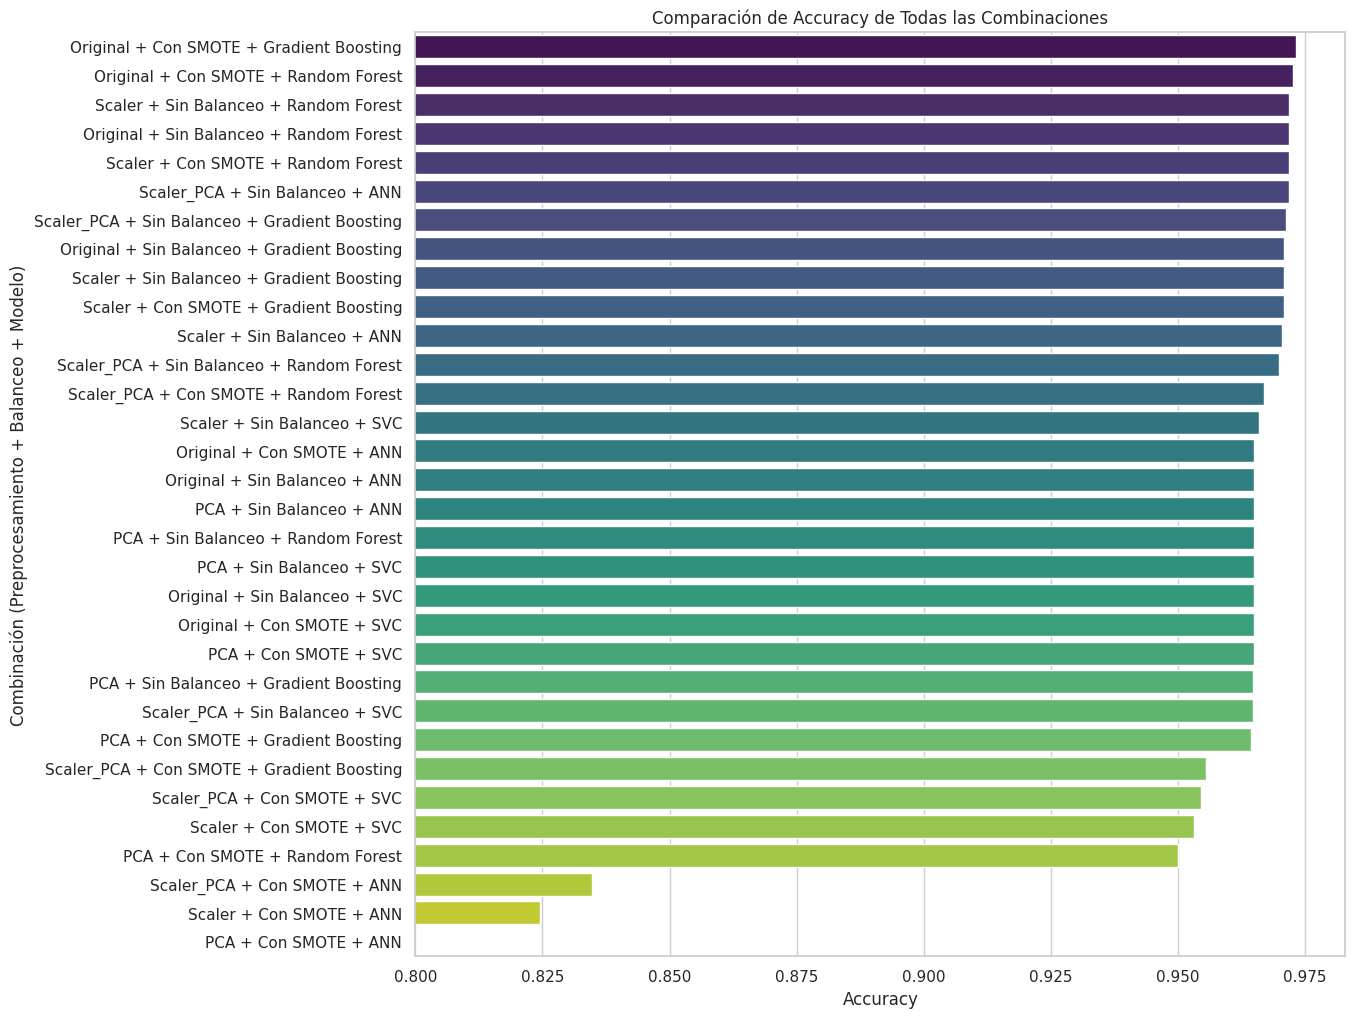


--- Conclusión ---
La mejor combinación fue:
Original + Con SMOTE + Gradient Boosting
Alcanzando un accuracy de: 0.9732


In [7]:
# Convertir el diccionario de resultados a un DataFrame para una mejor visualización
results_df = pd.DataFrame(list(results.items()), columns=['Combinacion', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("--- Tabla Comparativa de Resultados (Ordenados por Accuracy) ---")
print(results_df)

# Visualizar los resultados para una comparación más clara
plt.figure(figsize=(12, 12))
sns.barplot(x='Accuracy', y='Combinacion', data=results_df, palette='viridis')
plt.title('Comparación de Accuracy de Todas las Combinaciones')
plt.xlabel('Accuracy')
plt.ylabel('Combinación (Preprocesamiento + Balanceo + Modelo)')
plt.xlim(0.8, max(results_df['Accuracy']) * 1.01) # Ajustar el límite para ver mejor las diferencias
plt.show()

print("\n--- Conclusión ---")
if not results_df.empty:
    print(f"La mejor combinación fue:\n{results_df.iloc[0]['Combinacion']}")
    print(f"Alcanzando un accuracy de: {results_df.iloc[0]['Accuracy']:.4f}")
else:
    print("No se generaron resultados para mostrar.")

## Conclusiones Finales del Análisis de Modelos


Tras aplicar distintas estrategias de **preprocesamiento**, **balanceo de clases** y **modelos de clasificación**, se evaluó el rendimiento de más de 30 combinaciones posibles.  
El objetivo fue determinar qué configuración ofrecía el mejor equilibrio entre desempeño, estabilidad y simplicidad de implementación.


### 1. Desempeño general de los modelos
Los resultados muestran que los modelos basados en **árboles de decisión**, especialmente **Gradient Boosting** y **Random Forest**, dominaron la comparación en términos de *accuracy*.  
Las mejores combinaciones alcanzaron valores cercanos al **97.3%**, lo que demuestra su capacidad para manejar datos desbalanceados y con alta dimensionalidad.


### 2. Mejores configuraciones
- La **mejor combinación global** fue:
  - **Original + Con SMOTE + Gradient Boosting**,  
    con un **accuracy de 0.9732**.
- Le siguieron de cerca:
  - **Original + Con SMOTE + Random Forest** (0.9726)
  - **Scaler + Sin Balanceo + Random Forest** (0.9718)
- En general, el uso de **SMOTE** resultó beneficioso para los modelos basados en árboles, pero no para redes neuronales.


### 3. Comportamiento de las Redes Neuronales (ANN)
- Las ANN obtuvieron resultados competitivos en configuraciones con datos **escalados y sin balanceo** (≈97%), pero su rendimiento se degradó fuertemente al aplicar **SMOTE**.
- Esto sugiere que el sobreajuste a los datos sintéticos afecta su capacidad de generalización.


### 4. Efecto del preprocesamiento
- La normalización o **escalado de características (Scaler)** fue positiva en la mayoría de los modelos.
- La aplicación de **PCA** no mejoró el rendimiento de manera significativa, y en algunos casos redujo la precisión.
- El balanceo con **SMOTE** fue útil en modelos basados en árboles, pero contraproducente en redes neuronales.


### 5. Conclusión general
- **Gradient Boosting** demostró ser el modelo más robusto, logrando el mejor rendimiento global incluso con datos balanceados artificialmente.  
- **Random Forest** mostró un desempeño muy cercano, siendo una alternativa más rápida y estable.  
- Las **ANN** pueden ser útiles, pero requieren un ajuste cuidadoso y son más sensibles al preprocesamiento.
- En este conjunto de datos, la combinación **Original + SMOTE + Gradient Boosting** representa el **mejor compromiso entre exactitud y consistencia**.


En conjunto, el análisis demuestra que los modelos de tipo ensamble basados en árboles siguen siendo una de las opciones más sólidas para problemas de clasificación con alto desbalance y gran volumen de datos.




In [8]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score


# 2. Entrenar un modelo de Regresión Logística
# Se crea una instancia del modelo y se entrena con los datos
model = LogisticRegression(max_iter=1000000)
model.fit(X_train, y_train)
print("✅ Modelo entrenado.")

# (Opcional) Evaluar el modelo recién entrenado para ver su rendimiento
predictions_before_saving = model.predict(X_test)
accuracy_before = accuracy_score(y_test, predictions_before_saving)
print(f"   - Precisión (antes de guardar): {accuracy_before:.4f}")


####################################### acá se guarda el modelo
# 3. Guardar el modelo entrenado en un archivo
# El objeto 'model' que contiene todo el aprendizaje se guarda en un archivo.
model_filename = 'modelo.pkl'
joblib.dump(model, model_filename)
print(f"✅ Modelo guardado exitosamente como '{model_filename}'")



✅ Modelo entrenado.
   - Precisión (antes de guardar): 0.9642
✅ Modelo guardado exitosamente como 'modelo.pkl'


/home/pier/mi_venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 12529 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
